<a href="https://colab.research.google.com/github/Israelchguevara/Deteccion-de-profesiones-en-Twitter/blob/main/Deteccion_de_profesiones_en_Twitter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets
!pip install evaluate
!pip install fsspec==2023.9.2
!pip install transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.4/173.4 kB 6.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2023.9.2 which is incompatible.


## Imports

In [2]:
# Add your imports here
import numpy as np
import nltk
nltk.download('stopwords')
import os, random
import torch

SEED = 42

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

try:
    import torch
    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEED)
except Exception as e:
    print("Aviso: PyTorch no encontrado o sin GPU. Detalle:", e)


try:
    from transformers import set_seed
    set_seed(SEED)
except Exception as e:
    print("Aviso: Transformers no encontrado todavía. Asegúrate de instalarlo antes. Detalle:", e)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# 🔍 Detección de profesiones en tweets

## Enunciado

En este ejercicio vamos a trabajar con un conjunto de datos procedente de medios sociales online.

Utilizaremos un subconjunto de los datos de la proyecto 1 del shared task [**ProfNER**](https://temu.bsc.es/smm4h-spanish), centrada en la detección de menciones a profesiones en tweets publicados durante la pandemia del COVID-19. El objetivo original de la proyecto era analizar que profesiones podrían haber sido especialmente vulnerables en el contexto de la crisis sanitaria.

Para simplificar el ejercicio, he preparado una versión reducida del dataset original. Tu proyecto será entrenar un clasificador binario basado en la arquitectura Transformers, que, dado un tweet, determine si contiene una mención explícita a una profesión (etiqueta `1`) o no (etiqueta `0`).




✅ **Objetivos del ejercicio**

A lo largo de este notebook, completarás las siguientes etapas para construir un clasificador de menciones a profesiones en tweets:

1. **Análisis Exploratorio de Datos (EDA)**: Calcular estadísticas básicas del conjunto de datos (como el número de ejemplos del training set, la distribución de clases del dataset, la longitud media de los textos) o crear visualizaciones para cmprender mejor el contenido de los documentos usando wordclouds o histogramas.

2. **Selección y justificación del modelo**: Elegir un modelo del Hub de Huggingface adecuado para los datos con los que se va a trabajar y el tipo de proyecto a desarrollar.

3. **Entrenamiento del clasificador**: Entrenar el modelo de forma reproducible y evaluar su rendimiento sobreel conjunto de datos de validación, incluyendo un classification score y matriz de confusion

4. **Generación de predicciones sobre el conjunte de test**: Aplicar el modelo entrenado al conjunto de test, y guardar las predicciones en un archivo `.tsv` de 2 columnas `id` y `label` separadas por tabulador

## Obtención de datos

Descargamos los datos del [repositorio de Huggingface](https://huggingface.co/datasets/luisgasco/profner_classification_master).

In [3]:
#NO-MODIFY: DATA LOAD
from datasets import load_dataset, Dataset, DatasetDict, ClassLabel
dataset = load_dataset("luisgasco/profner_classification_master")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/480k [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/162k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/166k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2786 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/999 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1001 [00:00<?, ? examples/s]

El dataset contiene tres subsets:
- **train** y **validation**: Contienen el identificador del tweet, el texto, y su etiqueta, que podrá tener valor 1, si contiene una mención de una profesión; o valor 0, si no contiene una mención de una profesión.
- **test**: El test set tambiíen contiene la información de label por un requerimiento de Huggingface, pero el contenido de esta variable es siempre "-1". Es decir que deberéis predecir nuevas etiquetas una vez hayáis entrenado el modelo utilizando el train y el validation set.

## Análisis exploratorio de datos

Para hacer el análisis exploratorio de datos, transformamos cada subset a un pandas dataframe para mayor comodidad.

In [4]:
#NO-MODIFY: DATA LOAD
dataset_train_df = dataset["train"].to_pandas()
dataset_val_df = dataset["validation"].to_pandas()
dataset_test_df = dataset["test"].to_pandas()

**Número de documentos**

Obten con la función `get_num_docs_evaluation()` el número de documentos del dataset de training y validation.

> Recuerda incorporar la información para el cálculo dentro del a siguiente celda, sin modificar los atributos de entrada ni de salida de la función, ni su nombre.

In [5]:
#MODIFY: ADD INFO TO SOLVE FUNCTION
def get_num_docs_evaluation(dataset_df):
  # Modifica la función.
  num_docs = len(dataset_df)

  # No modifiques el return
  return num_docs

Una vez generada la función, puedes utilizarla posteriormente para calcular resultados y comentarlos

In [6]:
# Aplica la función
num_docs_train = get_num_docs_evaluation(dataset_train_df)
num_docs_val = get_num_docs_evaluation(dataset_val_df)

print(f"Number of documents in training set: {num_docs_train}")
print(f"Number of documents in validation set: {num_docs_val}")

Number of documents in training set: 2786
Number of documents in validation set: 999


**Número de documentos duplicados**

Obten con la función `detect_duplicates_evaluation()` el número de documentos duplicados del dataset de training y validation.

> Recuerda incorporar la información para el cálculo dentro del a siguiente celda, sin modificar los atributos de entrada ni de salida de la función, ni su nombre.

In [7]:
#MODIFY: ADD INFO TO SOLVE FUNCTION
def detect_duplicates_evaluation(dataset_df):
  # Modifica la función.
  num_duplicates = dataset_df.duplicated().sum()

  # No modifiques el return
  return num_duplicates

Una vez generada la función, puedes utilizarla posteriormente para calcular resultados y comentarlos

In [8]:
# Aplica la función
num_duplicates_train = detect_duplicates_evaluation(dataset_train_df)
num_duplicates_val = detect_duplicates_evaluation(dataset_val_df)

print(f"Number of duplicate documents in training set: {num_duplicates_train}")
print(f"Number of duplicate documents in validation set: {num_duplicates_val}")

Number of duplicate documents in training set: 0
Number of duplicate documents in validation set: 0


**Número de documentos por cada clase:**


Obten con la función `analyse_num_labels_evaluation()` para calcular el número de documentos de cada categoría en el dataset

> Recuerda incorporar la información para el cálculo dentro del a siguiente celda, sin modificar los atributos de entrada ni de salida de la función, ni su nombre.

In [9]:
#MODIFY: ADD INFO TO SOLVE FUNCTION
def analyse_num_labels_evaluation(dataset_df):
  # Modifica la función.
  num_positives = dataset_df[dataset_df['label'] == 1].shape[0]
  num_negatives = dataset_df[dataset_df['label'] == 0].shape[0]

  # No modifiques el return
  return num_positives, num_negatives

Una vez generada la función, puedes utilizarla posteriormente para calcular resultados y comentarlos

In [10]:
# Aplica la función
num_positives_train, num_negatives_train = analyse_num_labels_evaluation(dataset_train_df)
num_positives_val, num_negatives_val = analyse_num_labels_evaluation(dataset_val_df)

print(f"Training set: Positive examples: {num_positives_train}, Negative examples: {num_negatives_train}")
print(f"Validation set: Positive examples: {num_positives_val}, Negative examples: {num_negatives_val}")


Training set: Positive examples: 1393, Negative examples: 1393
Validation set: Positive examples: 238, Negative examples: 761


**Distribución de la longitud de los tweet en caracteres:**

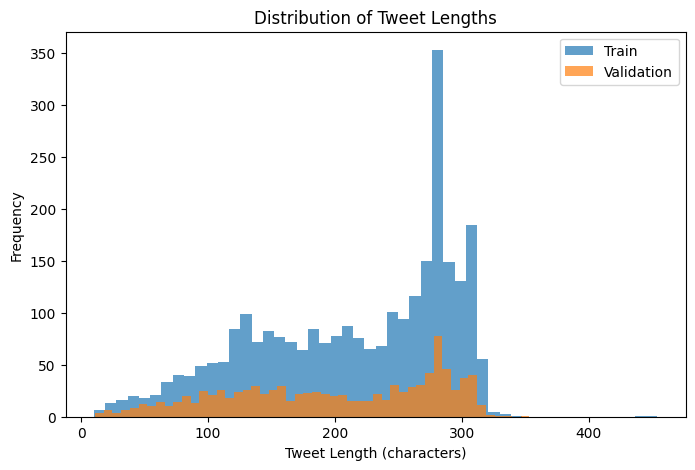

In [11]:
import matplotlib.pyplot as plt

# Calculate the length of each tweet
dataset_train_df['tweet_length'] = dataset_train_df['text'].apply(len)
dataset_val_df['tweet_length'] = dataset_val_df['text'].apply(len)

# Plot the distribution of tweet lengths
plt.figure(figsize=(8, 5))
plt.hist(dataset_train_df['tweet_length'], bins=50, alpha=0.7, label='Train')
plt.hist(dataset_val_df['tweet_length'], bins=50, alpha=0.7, label='Validation')
plt.xlabel('Tweet Length (characters)')
plt.ylabel('Frequency')
plt.title('Distribution of Tweet Lengths')
plt.legend()
plt.show()

**Interpretación del gráfico de Distribución de la Longitud de los Tweets:**

El histograma visualiza cómo se distribuye la longitud (en caracteres) de los tweets en tus conjuntos de datos de entrenamiento y validación.

Al observar este histograma, puedes entender características clave de tus datos, como:

*   **La longitud más común:** La barra más alta indica el rango de longitud donde se concentra la mayor cantidad de tweets.
*   **La dispersión de las longitudes:** Puedes ver si las longitudes están muy agrupadas o si hay una amplia variación.
*   **Presencia de tweets muy cortos o muy largos:** Los extremos del histograma te mostrarán si hay una cantidad significativa de tweets con longitudes inusuales.
*   **Comparación entre conjuntos:** Las barras para el conjunto de entrenamiento (azul) y validación (naranja) te permiten ver si la distribución de longitudes es similar en ambos conjuntos.

Este análisis es útil para tareas de procesamiento de texto, ya que puede guiar decisiones sobre la longitud máxima a considerar para la tokenización o el padding.

**Análisis de contenido de los tweets**

Para ello utiliza wordclouds

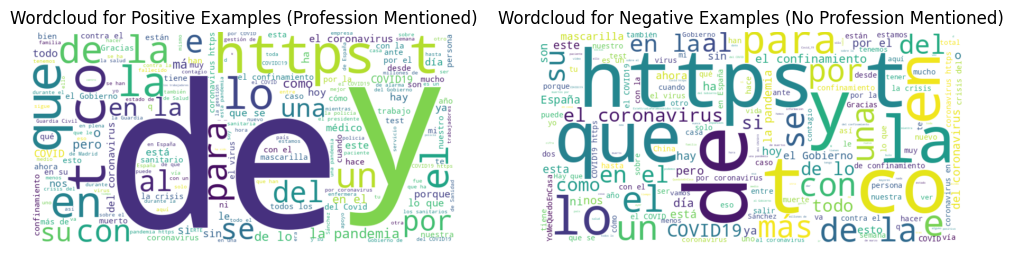

In [12]:
!pip install wordcloud

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine text from positive and negative examples
positive_text = " ".join(dataset_train_df[dataset_train_df['label'] == 1]['text'])
negative_text = " ".join(dataset_train_df[dataset_train_df['label'] == 0]['text'])

# Create wordcloud for positive examples
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_text)

# Create wordcloud for negative examples
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

# Display the wordclouds
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud for Positive Examples (Profession Mentioned)')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud for Negative Examples (No Profession Mentioned)')

plt.show()

**Interpretación de Wordclouds:**

*   **"Wordcloud for Positive Examples (Profession Mentioned)"**: Esta wordcloud visualiza las palabras que aparecen con mayor frecuencia en los tweets del conjunto de entrenamiento que han sido etiquetados con la clase `1`. La etiqueta `1` en este conjunto de datos indica que el tweet **contiene una mención explícita a una profesión**. Por lo tanto, esta wordcloud te muestra las palabras más comunes en los tweets donde se habla de profesiones.

*   **"Wordcloud for Negative Examples (No Profession Mentioned)"**: Esta wordcloud visualiza las palabras que aparecen con mayor frecuencia en los tweets del conjunto de entrenamiento que han sido etiquetados con la clase `0`. La etiqueta `0` en este conjunto de datos indica que el tweet **no contiene una mención explícita a una profesión**. Esta wordcloud, por lo tanto, te muestra las palabras más comunes en los tweets que no hablan de profesiones.

Comparar estas dos wordclouds te permite identificar visualmente las palabras que son más distintivas o frecuentes en cada una de las dos categorías de tweets, lo cual es un paso útil en el análisis exploratorio para entender las diferencias entre las clases.

## Tokenización

El texto del dataset no está preparado para ser introducido en un modelo Transformers. Lleva a cabo el proceso de tokenización.

In [13]:
# IMPORTS
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

Selecciona un modelo apropiado para la proyecto:

> Recuerda que en la siguiente celda sólo debes asignar un valor a model_name. No añadas más información en la celda.

In [14]:
#NO-MODIFY: VARIABLE NAME
# BERT-based model trained on Spanish data
model_name = 'dccuchile/bert-base-spanish-wwm-cased'

## Justificación del modelo

Para este ejercicio se emplea **BETO** (`dccuchile/bert-base-spanish-wwm-cased`), un BERT preentrenado **específico para español** y con **Whole Word Masking (WWM)**. Las razones de esta elección son:

- **Adecuación al idioma**: el corpus de preentrenamiento es español, lo que mejora la cobertura léxica, morfológica y fenómenos propios del idioma frente a modelos multilingües.
- **WWM**: enmascara palabras completas durante el preentrenamiento, beneficiando tareas de clasificación de texto donde la integridad de las unidades léxicas aporta señal.
- **Balance capacidad/recursos**: tamaño base (~110M parámetros), entrenable en una GPU de docencia con tiempos razonables.
- **Resultados contrastados**: BETO ha mostrado buen rendimiento en múltiples tareas de PLN en español (clasificación, NER, análisis de sentimiento), por lo que es una opción sólida como baseline fuerte.

Alternativas razonables serían **mBERT** o modelos recientes como **roberta-base-bne** (es-core news) o **ALBERT/DeBERTa** adaptados al español, pero BETO ofrece un equilibrio muy adecuado entre rendimiento y coste computacional para este entorno docente.


Puedes continuar con el proceso aquí:

In [15]:
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenize the datasets
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

tokenizer_config.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/648 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

Map:   0%|          | 0/2786 [00:00<?, ? examples/s]

Map:   0%|          | 0/999 [00:00<?, ? examples/s]

Map:   0%|          | 0/1001 [00:00<?, ? examples/s]

## Fine-tuning

Carga el model para ser ajustado posteriormente:

In [16]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Configuracion training_args

Configura los parámetros de entrenamiento del modelo.


>

> Recuerda que en la siguiente celda sólo debes asignar atributos a la variable training_args. No añadas  otras variables en la celda

In [17]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    seed=SEED,
    output_dir="./results",  # Directorio de salida para los resultados del entrenamiento
    learning_rate=2e-5,  # Tasa de aprendizaje
    per_device_train_batch_size=32,  # Tamaño del batch por dispositivo para entrenamiento
    per_device_eval_batch_size=32,  # Tamaño del batch por dispositivo para evaluación
    num_train_epochs=3,  # Número de épocas de entrenamiento
    weight_decay=0.01,  # Decaimiento del peso
    do_train=False,
    do_eval=True,
    logging_dir="./logs",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=tokenized_datasets["validation"],
)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [18]:
import numpy as np
import evaluate

metric = evaluate.load("f1")

import evaluate, numpy as np
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")
accuracy_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "precision": precision_metric.compute(predictions=preds, references=labels, average="binary")["precision"],
        "recall":    recall_metric.compute(predictions=preds, references=labels, average="binary")["recall"],
        "f1":        f1_metric.compute(predictions=preds, references=labels, average="binary")["f1"],
        "accuracy":  accuracy_metric.compute(predictions=preds, references=labels)["accuracy"],
    }


### Ajuste del modelo

Lleva a cabo el ajuste del modelo:

In [20]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    compute_metrics=compute_metrics,
)

trainer.train()

Step,Training Loss


TrainOutput(global_step=264, training_loss=0.2514055714462743, metrics={'train_runtime': 769.6476, 'train_samples_per_second': 10.86, 'train_steps_per_second': 0.343, 'total_flos': 2199082200698880.0, 'train_loss': 0.2514055714462743, 'epoch': 3.0})

In [21]:
trainer.evaluate()

{'eval_loss': 0.22377339005470276,
 'eval_precision': 0.8168498168498168,
 'eval_recall': 0.9369747899159664,
 'eval_f1': 0.87279843444227,
 'eval_accuracy': 0.934934934934935,
 'eval_runtime': 31.5377,
 'eval_samples_per_second': 31.676,
 'eval_steps_per_second': 1.015,
 'epoch': 3.0}

In [23]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Assuming y_true and y_pred are already available from a previous prediction/evaluation step
# If not, you would need to run trainer.predict() first to get them.
# Based on the notebook state, y_true and y_pred were generated in cell ZUkg3iH7Uf7m

# Generate classification report
report = classification_report(y_true, y_pred, target_names=["No Profession", "Profession"]) # Assuming class names based on previous analysis

print("Classification Report for Validation Set:")
print(report)

print("\n" + "="*50 + "\n") # Separator for clarity

# Generate and display confusion matrix (Code moved from cell ZUkg3iH7Uf7m)
cm = confusion_matrix(y_true, y_pred)

# Define class labels for display
class_names = ["No Profession", "Profession"] # Assuming 0 is No Profession and 1 is Profession based on previous analysis

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Validation Set")
plt.show()

NameError: name 'y_true' is not defined

## Genera predicciones

Genera predicciones sobre el test set. Recuerda que el archivo que generes y adjuntes al ejercicio debe tener dos columnas:


| id         | label |
|------------|-------|
| 1234567890 | 1     |
| 1234567891 | 0     |
| 1234567892 | 0     |
| 1234567893 | 1     |

- El archivo debe estar en formato **TSV** (separado por tabuladores).
- Debe contener exactamente **dos columnas**: `id` y `label`.
- Es obligatorio incluir la **cabecera**.


In [ ]:
tokenized_datasets["test"]["label"][0:4]

In [ ]:
def fix_labels(example):
    example["label"] = 1  # O lo que toque
    return example
ClassLabel
# Aplica la función al dataset de evaluación
dataset_test = tokenized_datasets["test"].map(fix_labels)

In [ ]:
label2id = {"SIN_PROFESION":0, "CON_PROFESION":1}

#NO-MODIFY: DATA LOAD
from datasets import load_dataset, Dataset, DatasetDict, ClassLabel
dataset = load_dataset("luisgasco/profner_classification_master")

dataset_test = dataset["test"]

In [ ]:
x_id = [x["tweet_id"] for x in dataset_test]
documentos = [x["text"] for x in dataset_test]

In [ ]:
documentos[0:3]

In [ ]:
from tqdm import tqdm
import torch
batch_size = 32
preds = []

for i in tqdm(range(0, len(documentos), batch_size)):
    batch = documentos[i:i+batch_size]
    # Tokenizar el batch
    tokenized_batch = tokenizer(batch, padding="max_length", truncation=True, return_tensors="pt")
    with torch.no_grad():
        # Mover el batch tokenizado al mismo dispositivo que el modelo
        tokenized_batch = {k: v.to(model.device) for k, v in tokenized_batch.items()}
        batch_preds = model(**tokenized_batch)
    preds.extend(batch_preds.logits)

In [ ]:
import numpy as np

# Get the predicted labels from the logits
predicted_labels = [np.argmax(p.cpu().numpy()) for p in preds]

# Create the num_preds list
num_preds = predicted_labels

In [ ]:
import pandas as pd
output_df2 = pd.DataFrame(
    {'id': x_id,
     'label': num_preds
    })

In [ ]:
output_df2.head(3)

In [ ]:
output_df2.to_csv("GUEVARA_AGUAS_ISRAEL_ejercicio1_predicciones.tsv", sep="\t",index=False)

In [ ]:
output_df2

In [ ]:
from google.colab import files
files.download("predicciones.tsv")